The notebook helps to explain the most recent hardware build for EECS744-Red Pitaya Developement Board. There are 6 peripherals built into the FPGA at the following offsets.

    0x00: gpio controller
    0x10: complex multiplier
    0x20: DDS based am-tone generator
    0x30: BRAM base AWG
    0x40: BRAM based Acquisition
    0x50: HBF Bank and decimation

First we need to import some definitions and modules.

In [140]:
def bits2tc(x,w):
    return (x & (2**(w-1)-1)) - (x & (2**(w-1)));

def tc2bits(x,w):
    return (x & (2**(w-1)-1)) + (x & (2**(w-1)));

In [141]:
import uio0
import time
import random
import numpy as np;
%matplotlib notebook
import matplotlib.pyplot as plt;

The gpio controller is at addresses 0x00 (in/out value) and 0x04 (pin direction).  The last 8 bits control the leds, the 9th bit (index[8]) provides a trigger to the bram1 scope, and the 10th (index[9]) bit indicates if the scope is ready.  The upper bits are attached to the expansion connection on the dev board.  The code below reads the values then writes 0x55 to the leds.  Next, it lights the leds up in a knight rider type sequence.

In [154]:
print(hex(uio0.read32(0)));
uio0.write32(0x04,0xff);
uio0.write32(0x0,0x55);
print(hex(uio0.read32(0)));

x = 1;
for index in range(0,1000):
    if (x == 128):
        dir = -1;
    if (x == 1):
        dir = 1;
    if (dir == 1):
        x = x << 1;
    if (dir == -1):
        x = x >> 1;
    uio0.write32(0x00,x);
    time.sleep(.02);

0xffff0200
0xffff0255


There is a complex multiplier at addresses 0x10 and 0x14. Write concatenated inputs [16bit real,16bit imag] to addresses 0x10 and 0x14, and read 32bit real from 0x10 and 32bit imag from 0x14. The code below generates random values between -1000 and 1000 as inputs and outputs the result in a form that the input values on the left of the equal sign can be copied into matlab to check the output on the right of the equal sign.

In [144]:
xr = random.randint(-1000,1000);
xi = random.randint(-1000,1000);
yr = random.randint(-1000,1000);
yi = random.randint(-1000,1000);
uio0.write32(0x10,(tc2bits(xr,16) << 16) + tc2bits(xi,16));
uio0.write32(0x14,(tc2bits(yr,16) << 16) + tc2bits(yi,16));
zr = bits2tc(uio0.read32(0x10),32);
zi = bits2tc(uio0.read32(0x14),32);

print("(%d + %d*1i)*(%d + %d*1i) = (%d + %di)" % (xr,xi,yr,yi,zr,zi))

(292 + -670*1i)*(-831 + 636*1i) = (183468 + 742482i)


The dds based am-tone generator is at addresses 0x20 to 0x28.  Address 0x20 uses a 32 bit value to set the carrier frequency, address 0x24 sets the tone, and address 0x28 sets the amplitude (bits [7:0]);

The dds freqencies for 0x20 and 0x24 can be determined by the following equation where:

    rate limit:   L = bits[23:16]
    addr step:    S = bits[11:0]
    memory depth: D = 4096
    DAC Rate:     F = 125 MSPS


$$ f_{dds} = \frac{SF}{LD} $$

In [149]:
uio0.write32(0x20,0x00010021); # fcarrier = 33*125/4096 = 1 MHz
uio0.write32(0x24,0x003a0001); # tone     = 125/4096*117 = 526.16 MHz (close to upper c)
uio0.write32(0x28,0x000000ff); # full scale amplitude
print(hex(uio0.read32(0x20)));
print(hex(uio0.read32(0x24)));
print(hex(uio0.read32(0x28)));


0x10021
0x3a0001
0xff


The bram0 controller is use to write data from python to a 32-bit by 4096 line of block memory in the PL.  This memory is continuously read in the PL to dac_db.  The bram controller is at addresses 0x30 (addr) and 0x34 (data).  data reads/writes automatically increases the address.  The code below writes a ramp to the contents.

In [145]:
uio0.write32(0x30,0x00)
for index in range(0,4096):
    x = uio0.write32(0x34,index << 4);

The half band filter bank includes a dc-block followed by 5 half-band filter and output enables to decimate by 2, 4, 8, 16, 32.  The back is programmed through a 32-bit register at base address 0x43C00050.  The 32 bit register has 8x 4-bit fields with the following descriptions. Setting the register values is shown below and commented out above.

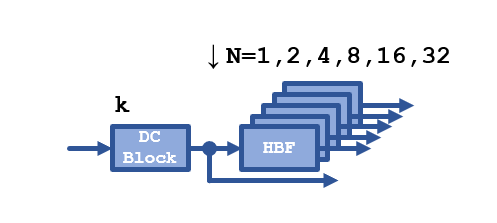

    1. bits[31:28] the "k" value of the dc block, where beta=2^k.
    
    2. bits[27:24] the decimation factor of the enable output.
        0: decimate by 2
        1: decimate by 4
        2: decimate by 8
        3: decimate by 16
        4: decimate by 32
        5: decimate by 1 or no decimation

    3. bits[23:20] the output tap.
        0: output of first hbf
        1: otuput of 2nd hbf
        2: output of 3rd hbf
        3: output of 4th hbf
        4: output of 5th hbf
        5: output of dc-block

Each HBF has a gain relating to width increase of approximately 15-bits. The remaining 5x 4-bit fields controll bitshifts of the HBF outputs to compensate for the gain increase.

    4. bits[19:16] bitshifts of the 5th HBF
    5. bits[15:12] bitshifts of the 4th HBF.
    6. bits[11:8] 3rd HBF
    7. bits[7:4] 2nd HBF
    8. bits[3:0] 1st HBF

The HBF controller is used below in the scope acquisition.

As second "bram1" controller is used to read data collected by the adc by storing acquisitions into a 32-bit by 4096 line of block memory in the PL.  Since the PL is capable of writing data to the memory much faster than it can be read by the PS bus, acquisitioned are captured using signals from the gpio controller to trigger the acquisition and HBF controller to adjust the decimation rate.  There is also a ready signal to check if an acquisition is currently in progress. 

<IPython.core.display.Javascript object>


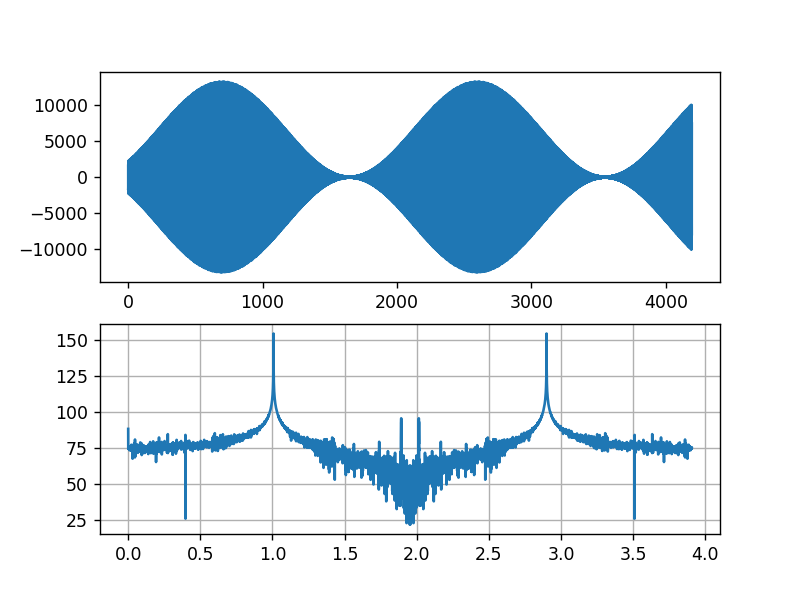

In [153]:
#make sure the scope is ready
ready = (uio0.read32(0x00) & 0x200) >> 9;
while (ready != 1):
    ready = (uio0.read32(0x00) & 0x200) >> 9;

#set HBF
uio0.write32(0x50,0x944edded);

#trigger
uio0.write32(0x04,0x1ff);
uio0.write32(0x0,0x000);
uio0.write32(0x0,0x100);
uio0.write32(0x0,0x000);

#start at address 0 and read 16384 samples
uio0.write32(0x40,0x00);
ch1 = np.zeros(16384, dtype=int);
ch2 = np.zeros(16384, dtype=int);
for index in range(0,16384):
    x = uio0.read32(0x44);
    ch1[index] = bits2tc((x & 0x0000ffff) >> 0,  16);
    ch2[index] = bits2tc((x & 0xffff0000) >> 16, 16);

#envelope detection (abs and moving average)
env = np.convolve(np.abs(ch1)-np.mean(np.abs(ch1)),np.ones(100),'same');

#plot the results
plt.figure(1);
plt.subplot(2,1,1);
plt.plot(np.arange(16384)*32/125,ch1);

plt.subplot(2,1,2);
plt.plot((125/32)*np.arange(16384)/16384,20*np.log10(abs(np.fft.fft(ch1))));
plt.grid();